<a href="https://colab.research.google.com/github/otakunoichin/test/blob/main/AI%E7%B6%B2%E8%86%9Cverify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step1: 環境準備
import os, re, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.9.0+cu126
cuda available: True
gpu: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# ★ここが新しい場所
DATA_ROOT = "/content/drive/MyDrive/AiFundas"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
LBL_DIR   = os.path.join(DATA_ROOT, "labels")

print("IMG_DIR:", IMG_DIR)
print("LBL_DIR:", LBL_DIR)
print("images sample:", os.listdir(IMG_DIR)[:10])
print("labels sample:", os.listdir(LBL_DIR)[:10])

Mounted at /content/drive
IMG_DIR: /content/drive/MyDrive/AiFundas/images
LBL_DIR: /content/drive/MyDrive/AiFundas/labels
images sample: ['001.jpg', '002.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.tif', '009.tif', '010.tif', '011.jpg']
labels sample: ['001.tif', '002.tif', '004.tif', '005.tif', '006.tif', '007.tif', '008.tif', '009.tif', '010.tif', '011.tif']


In [ ]:
def extract_id(path):
    base = os.path.basename(path)
    m = re.match(r"(\d+)\.(jpg|jpeg|png|tif|tiff)$", base, flags=re.IGNORECASE)
    if not m:
        return None
    return int(m.group(1))  # 001 -> 1

# images は jpg/tif 混在を想定して全部拾う
img_paths = []
for ext in ["jpg", "jpeg", "png", "tif", "tiff"]:
    img_paths += glob.glob(os.path.join(IMG_DIR, f"*.{ext}"))

# labels 側（tif中心）
lbl_paths = []
for ext in ["tif", "tiff", "png"]:
    lbl_paths += glob.glob(os.path.join(LBL_DIR, f"*.{ext}"))

img_map = {}
for p in img_paths:
    i = extract_id(p)
    if i is None:
        continue
    # 同じIDが複数拡張子でいたら「最初に見つけたもの」を採用
    # もしjpg優先にしたければここを改造できる
    if i not in img_map:
        img_map[i] = p

lbl_map = {}
for p in lbl_paths:
    i = extract_id(p)
    if i is None:
        continue
    if i not in lbl_map:
        lbl_map[i] = p

common_ids = sorted(set(img_map.keys()) & set(lbl_map.keys()))
only_img   = sorted(set(img_map.keys()) - set(lbl_map.keys()))
only_lbl   = sorted(set(lbl_map.keys()) - set(img_map.keys()))

print("images files:", len(img_paths), "unique IDs:", len(img_map))
print("labels files:", len(lbl_paths), "unique IDs:", len(lbl_map))
print("paired IDs:", len(common_ids))
print("only in images:", len(only_img), "example:", only_img[:10])
print("only in labels:", len(only_lbl), "example:", only_lbl[:10])

print("\n--- paired preview (first 10) ---")
for i in common_ids[:10]:
    print(i, "->", os.path.basename(img_map[i]), os.path.basename(lbl_map[i]))

images files: 35 unique IDs: 35
labels files: 35 unique IDs: 35
paired IDs: 35
only in images: 0 example: []
only in labels: 0 example: []

--- paired preview (first 10) ---
1 -> 001.jpg 001.tif
2 -> 002.jpg 002.tif
4 -> 004.jpg 004.tif
5 -> 005.jpg 005.tif
6 -> 006.jpg 006.tif
7 -> 007.jpg 007.tif
8 -> 008.tif 008.tif
9 -> 009.tif 009.tif
10 -> 010.tif 010.tif
11 -> 011.jpg 011.tif


ID: 1
image: uint8 (4000, 4000) min/max: 0 255 mean: 64.7684985
mask : uint8 (4000, 4000) min/max: 0 255 unique(head): [  0 255] unique_count: 2


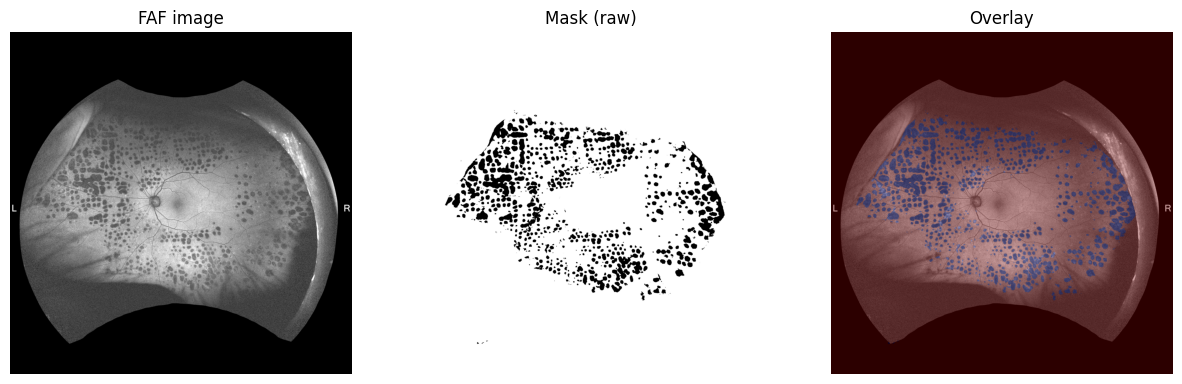

In [ ]:
def load_grayscale(path):
    img = Image.open(path).convert("L")
    return np.array(img)

def show_pair(k=0):
    img_id = common_ids[k]
    img = load_grayscale(img_map[img_id])
    msk = load_grayscale(lbl_map[img_id])

    print("ID:", img_id)
    print("image:", img.dtype, img.shape, "min/max:", img.min(), img.max(), "mean:", float(img.mean()))
    uniq = np.unique(msk)
    print("mask :", msk.dtype, msk.shape, "min/max:", msk.min(), msk.max(),
          "unique(head):", uniq[:20], "unique_count:", len(uniq))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap="gray"); ax[0].set_title("FAF image"); ax[0].axis("off")
    ax[1].imshow(msk, cmap="gray"); ax[1].set_title("Mask (raw)"); ax[1].axis("off")
    ax[2].imshow(img, cmap="gray")
    ax[2].imshow(msk, cmap="jet", alpha=0.35)
    ax[2].set_title("Overlay"); ax[2].axis("off")
    plt.show()

show_pair(0)

In [ ]:
PATCH_ROOT   = os.path.join(DATA_ROOT, "patches")
PATCH_IMGDIR = os.path.join(PATCH_ROOT, "images")
PATCH_LBLDIR = os.path.join(PATCH_ROOT, "labels")
os.makedirs(PATCH_IMGDIR, exist_ok=True)
os.makedirs(PATCH_LBLDIR, exist_ok=True)

TARGET_SIZE = 4096
PATCH_SIZE  = 512

def reflect_pad_to(arr, target=4096):
    h, w = arr.shape
    if h > target or w > target:
        raise ValueError(f"image too large: {arr.shape} > {target}")
    pad_h = target - h
    pad_w = target - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    arr_pad = np.pad(arr, ((top, bottom), (left, right)), mode="reflect")
    return arr_pad, (top, bottom, left, right)

def save_gray(arr, path):
    Image.fromarray(arr).save(path)

# 実行
total = 0
per_image = (TARGET_SIZE // PATCH_SIZE) * (TARGET_SIZE // PATCH_SIZE)

for img_id in common_ids:
    img = load_grayscale(img_map[img_id])
    msk = load_grayscale(lbl_map[img_id])

    img_pad, pad_info = reflect_pad_to(img, TARGET_SIZE)
    msk_pad, _        = reflect_pad_to(msk, TARGET_SIZE)

    # ★マスクを2値化して統一したい場合（おすすめ）
    # 0/255でも0/1でも「>0」を1とみなして 0/255 に統一
    msk_pad = ((msk_pad > 0).astype(np.uint8) * 255)

    for r in range(TARGET_SIZE // PATCH_SIZE):
        for c in range(TARGET_SIZE // PATCH_SIZE):
            y0 = r * PATCH_SIZE
            x0 = c * PATCH_SIZE
            img_p = img_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]
            msk_p = msk_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE]

            out_img = os.path.join(PATCH_IMGDIR, f"image_{img_id:06d}_r{r}_c{c}.png")
            out_msk = os.path.join(PATCH_LBLDIR, f"mask_{img_id:06d}_r{r}_c{c}.png")
            save_gray(img_p, out_img)
            save_gray(msk_p, out_msk)
            total += 1

print("paired images:", len(common_ids))
print("patches per image:", per_image)
print("total patches:", total)
print("expected total:", len(common_ids) * per_image)

paired images: 35
patches per image: 64
total patches: 2240
expected total: 2240


patch image count: 2240
patch mask  count: 2240
patch img shape: (512, 512) min/max: 0 0
patch msk shape: (512, 512) unique(head): [255]


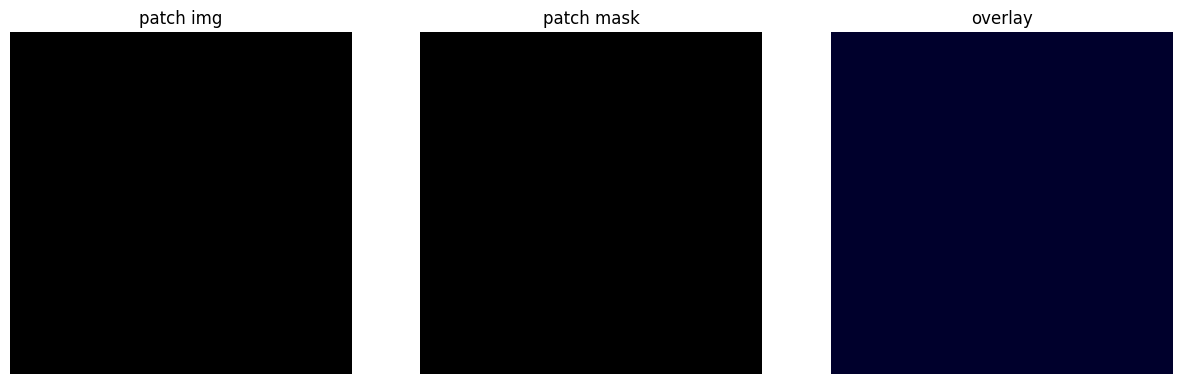

In [ ]:
patch_imgs = sorted(glob.glob(os.path.join(PATCH_IMGDIR, "*.png")))
patch_msks = sorted(glob.glob(os.path.join(PATCH_LBLDIR, "*.png")))

print("patch image count:", len(patch_imgs))
print("patch mask  count:", len(patch_msks))

# 1枚読み
img0 = np.array(Image.open(patch_imgs[0]).convert("L"))
msk0 = np.array(Image.open(patch_msks[0]).convert("L"))
print("patch img shape:", img0.shape, "min/max:", img0.min(), img0.max())
print("patch msk shape:", msk0.shape, "unique(head):", np.unique(msk0)[:10])

# overlayで表示
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img0, cmap="gray"); ax[0].set_title("patch img"); ax[0].axis("off")
ax[1].imshow(msk0, cmap="gray"); ax[1].set_title("patch mask"); ax[1].axis("off")
ax[2].imshow(img0, cmap="gray")
ax[2].imshow(msk0, cmap="jet", alpha=0.35)
ax[2].set_title("overlay"); ax[2].axis("off")
plt.show()

In [ ]:
import random

# patchesのファイルを集める
PATCH_IMGDIR = "/content/drive/MyDrive/AiFundas/patches/images"
PATCH_LBLDIR = "/content/drive/MyDrive/AiFundas/patches/labels"

patch_imgs = sorted(glob.glob(os.path.join(PATCH_IMGDIR, "*.png")))

def parse_patch_info(path):
    # image_000123_r3_c5.png -> id=123, r=3, c=5
    base = os.path.basename(path)
    m = re.match(r"image_(\d+)_r(\d+)_c(\d+)\.png$", base)
    if not m:
        return None
    img_id = int(m.group(1))
    r = int(m.group(2)); c = int(m.group(3))
    return img_id, r, c

# 画像ID一覧
all_ids = sorted({parse_patch_info(p)[0] for p in patch_imgs if parse_patch_info(p) is not None})
print("unique original IDs:", len(all_ids), "example:", all_ids[:10])

# 分割
random.seed(42)
ids = all_ids[:]
random.shuffle(ids)
val_ratio = 0.2
n_val = max(1, int(len(ids) * val_ratio))
val_ids = set(ids[:n_val])
train_ids = set(ids[n_val:])

print("train IDs:", len(train_ids), "val IDs:", len(val_ids))

# train/valのパッチ一覧を作る
train_img_paths, val_img_paths = [], []
for p in patch_imgs:
    info = parse_patch_info(p)
    if info is None:
        continue
    img_id, r, c = info
    if img_id in train_ids:
        train_img_paths.append(p)
    elif img_id in val_ids:
        val_img_paths.append(p)

print("train patches:", len(train_img_paths))
print("val patches  :", len(val_img_paths))

unique original IDs: 35 example: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
train IDs: 28 val IDs: 7
train patches: 1792
val patches  : 448


In [ ]:
from torch.utils.data import Dataset, DataLoader

class PatchSegDataset(Dataset):
    def __init__(self, img_paths, img_dir=PATCH_IMGDIR, lbl_dir=PATCH_LBLDIR, augment=False):
        self.img_paths = img_paths
        self.augment = augment

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        base = os.path.basename(img_path)  # image_000123_r0_c0.png
        lbl_base = base.replace("image_", "mask_")
        lbl_path = os.path.join(PATCH_LBLDIR, lbl_base)

        img = Image.open(img_path).convert("L")
        msk = Image.open(lbl_path).convert("L")

        img = np.array(img, dtype=np.float32) / 255.0               # [0,1]
        msk = (np.array(msk, dtype=np.uint8) > 0).astype(np.float32) # {0,1}

        # augment（軽め）
        if self.augment:
            if random.random() < 0.5:
                img = np.fliplr(img).copy()
                msk = np.fliplr(msk).copy()
            if random.random() < 0.5:
                img = np.flipud(img).copy()
                msk = np.flipud(msk).copy()
            # 90度回転（0,1,2,3）
            k = random.randint(0, 3)
            if k:
                img = np.rot90(img, k).copy()
                msk = np.rot90(msk, k).copy()

        # tensor: (C,H,W)
        img_t = torch.from_numpy(img).unsqueeze(0)  # 1x512x512
        msk_t = torch.from_numpy(msk).unsqueeze(0)  # 1x512x512

        return img_t, msk_t

train_ds = PatchSegDataset(train_img_paths, augment=True)
val_ds   = PatchSegDataset(val_img_paths, augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# 確認：1バッチ
xb, yb = next(iter(train_loader))
print("x:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("y:", yb.shape, yb.dtype, torch.unique(yb))

x: torch.Size([8, 1, 512, 512]) torch.float32 0.0 0.9686274528503418
y: torch.Size([8, 1, 512, 512]) torch.float32 tensor([0., 1.])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b  = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        logits = self.outc(d1)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_ch=1, out_ch=1, base=32).to(device)
print("model ready:", device)

model ready: cuda


In [ ]:
bce = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum(dim=(2,3)) + eps
    den = (probs+targets).sum(dim=(2,3)) + eps
    dice = num/den
    return 1 - dice.mean()

@torch.no_grad()
def dice_score_from_logits(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    num = 2*(pred*targets).sum(dim=(2,3)) + eps
    den = (pred+targets).sum(dim=(2,3)) + eps
    return (num/den).mean().item()

def loss_fn(logits, targets):
    return bce(logits, targets) + dice_loss_from_logits(logits, targets)

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

def run_one_epoch(model, loader, train=True):
    model.train(train)
    total_loss = 0.0
    total_dice = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = loss_fn(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_dice += dice_score_from_logits(logits, y) * x.size(0)
        n += x.size(0)

    return total_loss / n, total_dice / n

best_val = -1
ckpt_path = "/content/drive/MyDrive/AiFundas/best_unet.pt"

EPOCHS = 10
for ep in range(1, EPOCHS+1):
    tr_loss, tr_dice = run_one_epoch(model, train_loader, train=True)
    va_loss, va_dice = run_one_epoch(model, val_loader, train=False)

    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} dice {tr_dice:.4f} | val loss {va_loss:.4f} dice {va_dice:.4f}")

    if va_dice > best_val:
        best_val = va_dice
        torch.save({"model": model.state_dict(), "epoch": ep, "val_dice": va_dice}, ckpt_path)
        print("  saved best ->", ckpt_path)

Epoch 01 | train loss 0.5198 dice 0.9269 | val loss 0.3011 dice 0.9498
  saved best -> /content/drive/MyDrive/AiFundas/best_unet.pt
Epoch 02 | train loss 0.2963 dice 0.9490 | val loss 0.2686 dice 0.9485
Epoch 03 | train loss 0.2474 dice 0.9537 | val loss 0.2056 dice 0.9605
  saved best -> /content/drive/MyDrive/AiFundas/best_unet.pt
Epoch 04 | train loss 0.2270 dice 0.9566 | val loss 0.4460 dice 0.8770
Epoch 05 | train loss 0.2111 dice 0.9590 | val loss 0.2274 dice 0.9515
Epoch 06 | train loss 0.1960 dice 0.9615 | val loss 0.2280 dice 0.9546
Epoch 07 | train loss 0.1829 dice 0.9636 | val loss 0.1804 dice 0.9646
  saved best -> /content/drive/MyDrive/AiFundas/best_unet.pt
Epoch 08 | train loss 0.1808 dice 0.9637 | val loss 0.1832 dice 0.9639
Epoch 09 | train loss 0.1739 dice 0.9647 | val loss 0.1576 dice 0.9675
  saved best -> /content/drive/MyDrive/AiFundas/best_unet.pt
Epoch 10 | train loss 0.1656 dice 0.9664 | val loss 0.2069 dice 0.9571


In [ ]:
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()
print("loaded:", ckpt_path, "epoch:", ckpt["epoch"], "val_dice:", ckpt["val_dice"])

loaded: /content/drive/MyDrive/AiFundas/best_unet.pt epoch: 9 val_dice: 0.9674940918173108


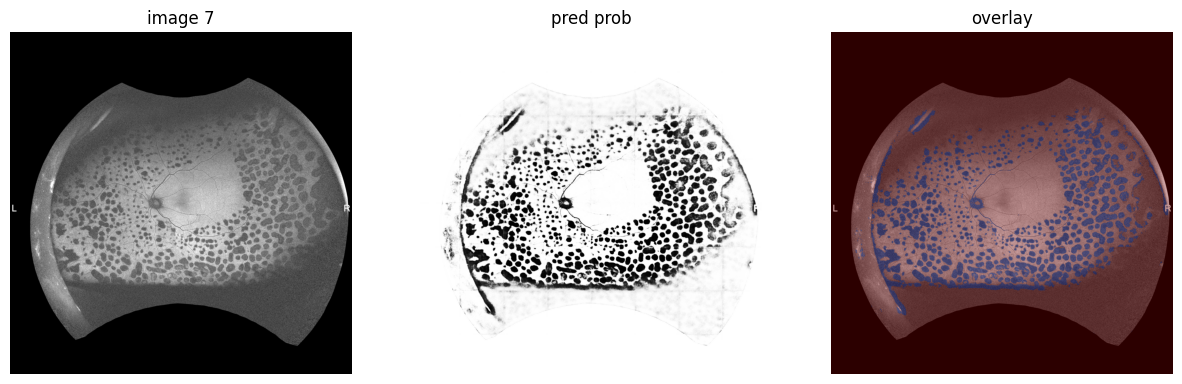

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000007.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000007.png


In [ ]:
@torch.no_grad()
def predict_one_id(img_id, thr=0.5, save_dir="/content/drive/MyDrive/AiFundas/predictions"):
    os.makedirs(save_dir, exist_ok=True)

    # 元画像とラベル（参考）を読み、元サイズを知る
    img0 = load_grayscale(img_map[img_id])
    H, W = img0.shape

    # pad情報を計算（Step5と同じ）
    pad_h = TARGET_SIZE - H
    pad_w = TARGET_SIZE - W
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # 4096キャンバスに確率（float）で再構成
    prob_canvas = np.zeros((TARGET_SIZE, TARGET_SIZE), dtype=np.float32)

    for r in range(TARGET_SIZE // PATCH_SIZE):
        for c in range(TARGET_SIZE // PATCH_SIZE):
            p_img = os.path.join(PATCH_IMGDIR, f"image_{img_id:06d}_r{r}_c{c}.png")
            if not os.path.exists(p_img):
                raise FileNotFoundError(p_img)

            arr = np.array(Image.open(p_img).convert("L"), dtype=np.float32) / 255.0
            x = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).to(device)  # 1x1x512x512
            logits = model(x)
            prob = torch.sigmoid(logits).squeeze().detach().cpu().numpy()    # 512x512

            y0 = r * PATCH_SIZE
            x0 = c * PATCH_SIZE
            prob_canvas[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = prob

    # 元サイズへクロップ
    prob_crop = prob_canvas[top:top+H, left:left+W]
    pred_bin = (prob_crop > thr).astype(np.uint8) * 255

    # 保存
    out_prob = os.path.join(save_dir, f"prob_{img_id:06d}.png")
    out_bin  = os.path.join(save_dir, f"pred_{img_id:06d}.png")
    Image.fromarray((prob_crop*255).astype(np.uint8)).save(out_prob)
    Image.fromarray(pred_bin).save(out_bin)

    # 可視化
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].imshow(img0, cmap="gray"); ax[0].set_title(f"image {img_id}"); ax[0].axis("off")
    ax[1].imshow(prob_crop, cmap="gray"); ax[1].set_title("pred prob"); ax[1].axis("off")
    ax[2].imshow(img0, cmap="gray")
    ax[2].imshow(pred_bin, cmap="jet", alpha=0.35)
    ax[2].set_title("overlay"); ax[2].axis("off")
    plt.show()

    print("saved:", out_prob)
    print("saved:", out_bin)

# 例：valに入っているIDを1つ試す（val_idsから適当に）
test_id = sorted(list(val_ids))[0]
predict_one_id(test_id, thr=0.5)

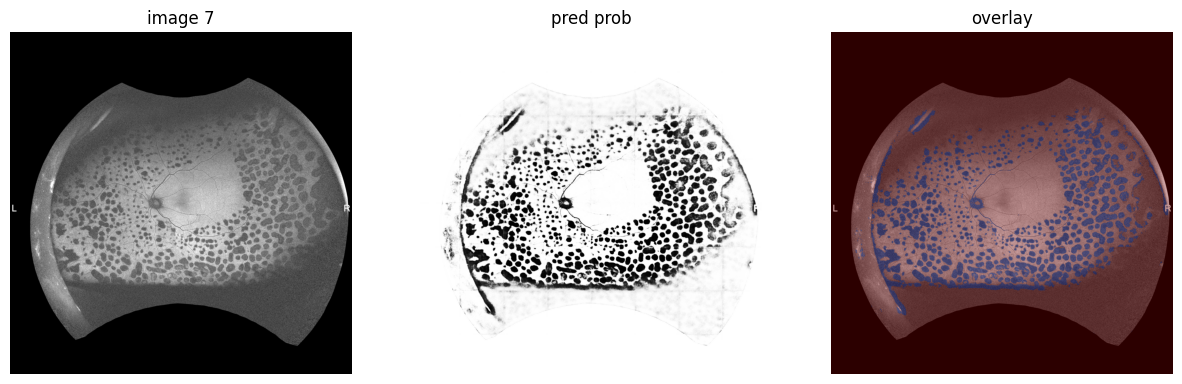

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000007.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000007.png


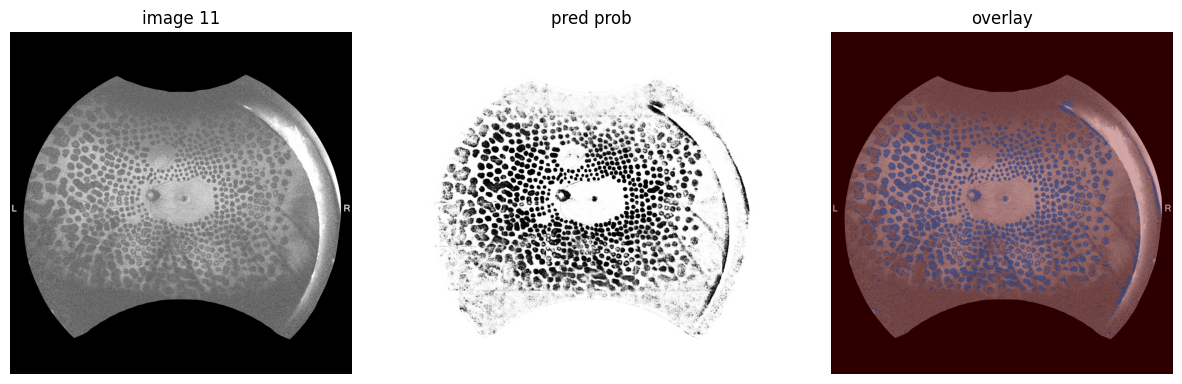

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000011.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000011.png


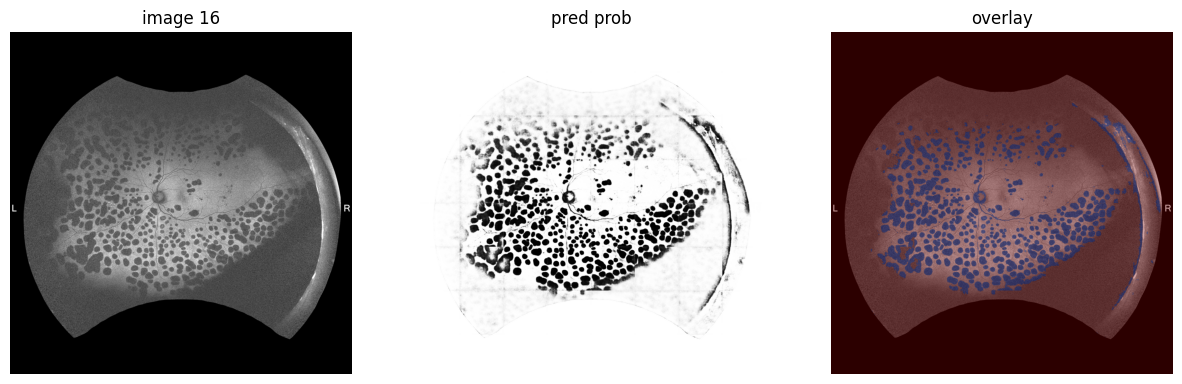

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000016.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000016.png


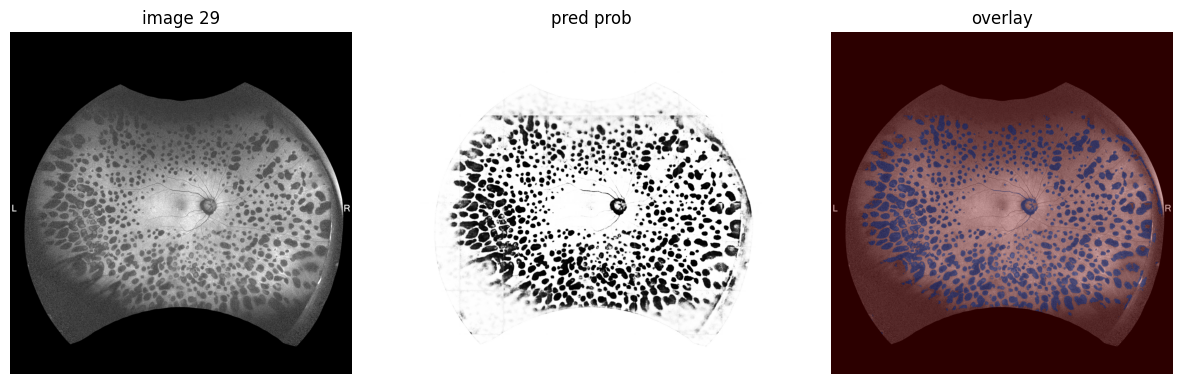

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000029.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000029.png


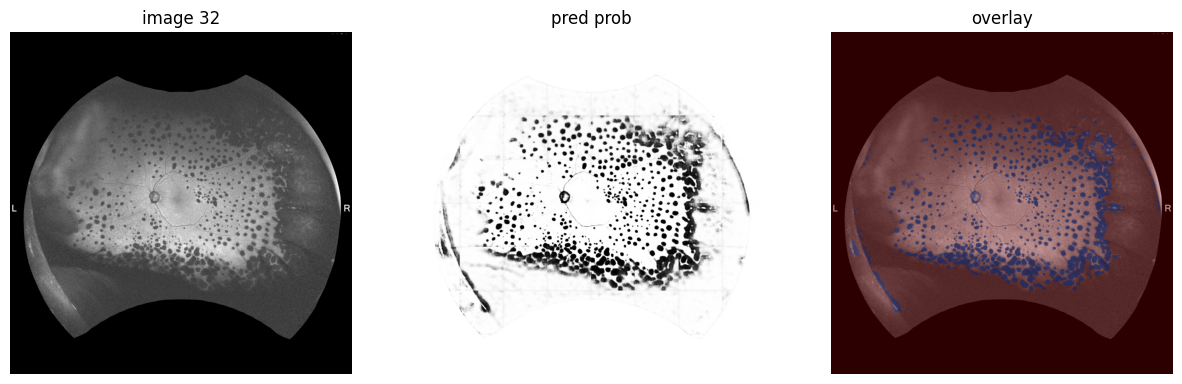

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000032.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000032.png


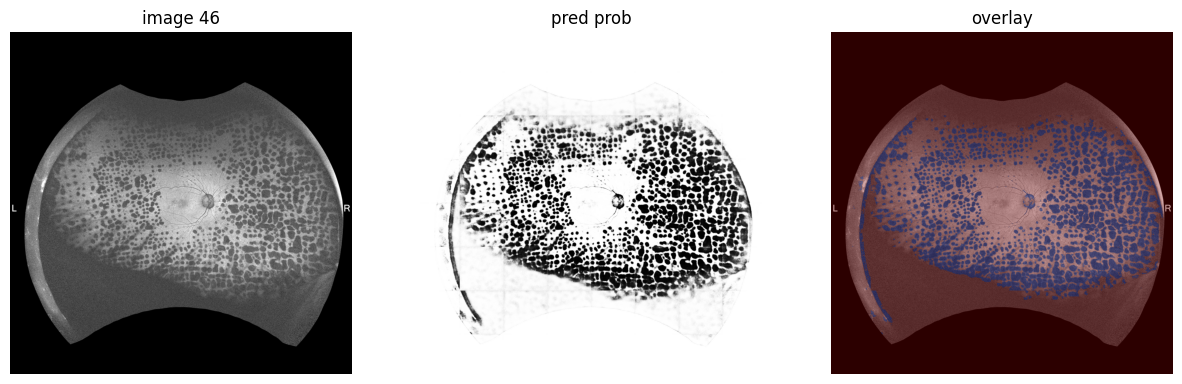

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000046.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000046.png


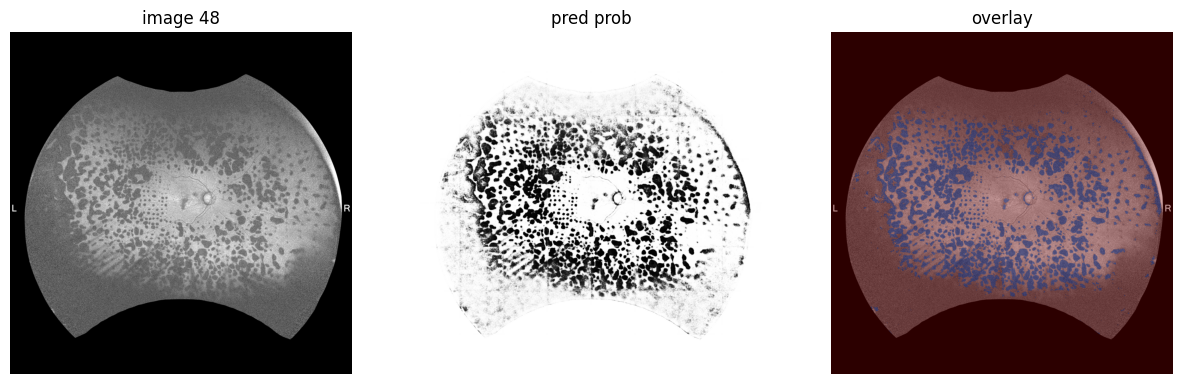

saved: /content/drive/MyDrive/AiFundas/predictions/prob_000048.png
saved: /content/drive/MyDrive/AiFundas/predictions/pred_000048.png


In [ ]:
for img_id in sorted(list(val_ids))[:10]:  # まずは5枚だけ
    predict_one_id(img_id, thr=0.5)